# Notebook to generate selectivity plots.

This notebook requires the cached selectivity data in
`../../../cache/phys_processing/selectivity`. See
`../../../phys_processing/selectivity` for details of how to generate this.

This notebook generates selectivity plots for both monkeys for both Triangle and
Ring datasets, and saves these plots to the current directory.

At the bottom of this notebook are also cells that print the number of units per
task, subject, brain area, and session.

In [1]:
"""Imports."""

from matplotlib import pyplot as plt
from matplotlib import patheffects
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [2]:
"""Load data."""

_DATA_DIR = Path('../../../cache/phys_processing/selectivity/')
_MEAN_FIRING_RATE_THRESHOLD = 1.

# Load data
dataframes = []
for subject_dir in _DATA_DIR.iterdir():
    if subject_dir.name.startswith('.'):
        continue
    for session_dir in subject_dir.iterdir():
        if session_dir.name.startswith('.'):
            continue
        new_df = pd.read_csv(session_dir / 'units.csv')
        dataframes.append(new_df)
df = pd.concat(dataframes).reset_index(drop=True)

# Remove units with too low mean firing rate
df = df[
    (df["task"] == "triangle") &
    (df["mean_firing_rate"] > _MEAN_FIRING_RATE_THRESHOLD)
]
df["p_significant"] = (
    (df['Position p-value'] < 0.05) |
    (df['Identity p-value'] < 0.05)
)

/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_28838/1930743932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["p_significant"] = (
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/matplotlib/

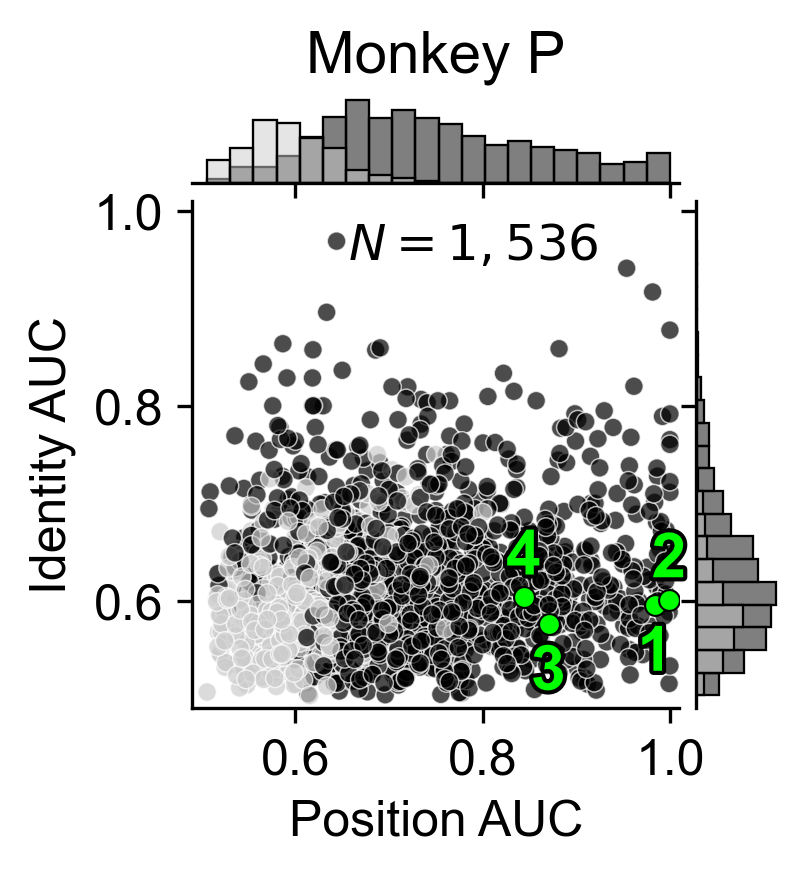

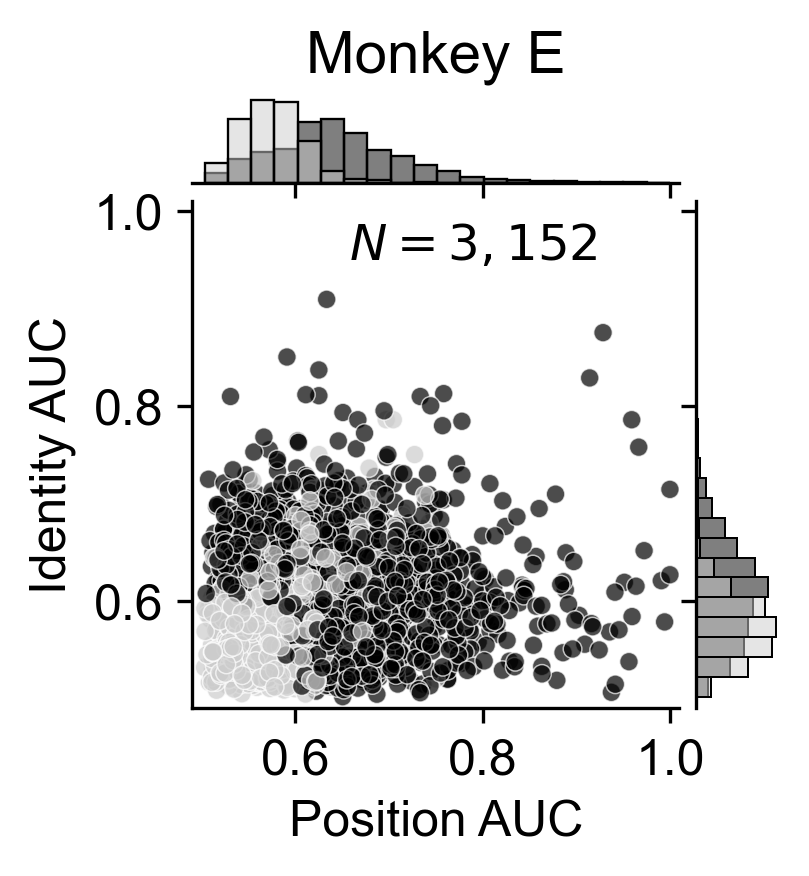

In [3]:
"""Scatterplot position and identity AUC values."""

for subject in ["Perle", "Elgar"]:
    sub_df = df[df['subject'] == subject]
    sub_df["p_significant"] = (
        (sub_df['Position p-value'] < 0.05) |
        (sub_df['Identity p-value'] < 0.05)
    )
    g = sns.JointGrid(
        data=sub_df,
        x="Position AUC",
        y="Identity AUC",
        xlim=(0.49, 1.01),
        ylim=(0.49, 1.01),
        height=2.8,
    )
    sns.scatterplot(
        ax=g.ax_joint,
        data=sub_df,
        x='Position AUC',
        y='Identity AUC',
        s=20,
        alpha=0.7,
        hue="p_significant",
        palette={True: (0, 0, 0), False: (0.8, 0.8, 0.8)},
        legend=False,
    )
    sns.histplot(
        ax=g.ax_marg_x,
        data=sub_df,
        x="Position AUC",
        hue="p_significant",
        palette={True: (0, 0, 0), False: (0.8, 0.8, 0.8)},
        kde=False,
        bins=20,
        legend=False,
    )
    sns.histplot(
        ax=g.ax_marg_y,
        data=sub_df,
        y="Identity AUC",
        hue="p_significant",
        palette={True: (0, 0, 0), False: (0.8, 0.8, 0.8)},
        kde=False,
        bins=20,
        legend=False,
    )
    g.figure.set_dpi(300)
    
    # Compute and display number of included points
    n_units = len(sub_df)
    g.ax_joint.text(0.79, 0.95, f'$N={n_units:,}$', fontsize=12, horizontalalignment='center')

    # If necessary, add stars for highlighted neurons
    if subject == "Perle":
        for unit_i, unit in enumerate([151, 154, 64, 71]):
            row = sub_df[
                (sub_df['unit'] == unit) &
                (sub_df['session'] == '2022-06-01')
            ]
            g.ax_joint.scatter(
                row['Position AUC'], row['Identity AUC'],
                color=(0, 1, 0), s=25, alpha=1., marker='o', edgecolor='black',
                linewidth=0.5,
            )
            text_kwargs = {
                'fontsize': 15,
                'color': (0, 1, 0),
                'fontweight': 'bold',
                'path_effects': [
                    patheffects.withStroke(linewidth=2, foreground='black')
                ]
            }
            if unit_i in [0, 2]:
                g.ax_joint.text(
                    row['Position AUC'] + 0.018, row['Identity AUC'] - 0.02,
                    f'{unit_i + 1}',
                    ha='right',
                    va='top',
                    **text_kwargs,
                )
            else:
                g.ax_joint.text(
                row['Position AUC'] + 0.018, row['Identity AUC'] + 0.07,
                f'{unit_i + 1}',
                ha='right',
                va='top',
                **text_kwargs,
            )
            
    # Make title
    g.ax_marg_x.set_title(f'Monkey {subject[:1]}')
    
    # Save figure
    g.savefig(f'./auc_{subject}.pdf', bbox_inches='tight', pad_inches=0.01)

In [7]:
"""Print number of units per subject, brain area, and session."""

print(f"Number of units: {len(df)}")
fef = df[df['probe'].str.contains('vprobe')]
dmfc = df[df['probe'].str.contains('s')]
print(f"    FEF: {len(fef)}")
print(f"    DMFC: {len(dmfc)}")

for subject in ["Perle", "Elgar"]:
    df_subject = df[df['subject'] == subject]
    fef = df_subject[df_subject['probe'].str.contains('vprobe')]
    dmfc = df_subject[df_subject['probe'].str.contains('s')]
    
    # Print number of units in each area
    print(f"    Subject: {subject}, Number of units: {len(df_subject)}")
    print(f"        FEF: {len(fef)}")
    print(f"        DMFC: {len(dmfc)}")
    
print("\nNumber of significant units per subject and session:")
for subject in ["Perle", "Elgar"]:
    df_subject = df[df['subject'] == subject]
    for session in sorted(df_subject["session"].unique()):
        df_session = df_subject[df_subject["session"] == session]
        num_units = np.sum(df_session.significant)
        print(f"{subject} {session}: {num_units}")

print("\nNumber of significant units per subject, session, and brain area:")
for subject in ["Perle", "Elgar"]:
    df_subject = df[df['subject'] == subject]
    for session in sorted(df_subject["session"].unique()):
        df_session = df_subject[df_subject["session"] == session]
        df_session_fef = df_session[df_session['probe'].str.contains('vprobe')]
        df_session_dmfc = df_session[df_session['probe'].str.contains('s')]
        num_units_fef = np.sum(df_session_fef.significant)
        num_units_dmfc = np.sum(df_session_dmfc.significant)
        print(f"{subject} {session} FEF: {num_units_fef}, DMFC: {num_units_dmfc}")

Number of units: 4688
    FEF: 1751
    DMFC: 2937
    Subject: Perle, Number of units: 1536
        FEF: 811
        DMFC: 725
    Subject: Elgar, Number of units: 3152
        FEF: 940
        DMFC: 2212

Number of significant units per subject and session:
Perle 2022-05-26: 64
Perle 2022-05-27: 71
Perle 2022-05-28: 69
Perle 2022-05-29: 63
Perle 2022-05-30: 121
Perle 2022-05-31: 131
Perle 2022-06-01: 178
Perle 2022-06-03: 108
Perle 2022-06-04: 133
Perle 2022-06-05: 56
Elgar 2022-08-19: 102
Elgar 2022-08-20: 125
Elgar 2022-08-21: 37
Elgar 2022-08-22: 98
Elgar 2022-08-23: 50
Elgar 2022-08-24: 123
Elgar 2022-08-25: 29
Elgar 2022-08-26: 40
Elgar 2022-08-31: 95
Elgar 2022-09-01: 62
Elgar 2022-09-02: 30
Elgar 2022-09-03: 69
Elgar 2022-09-04: 95
Elgar 2022-09-05: 56

Number of significant units per subject, session, and brain area:
Perle 2022-05-26 FEF: 21, DMFC: 43
Perle 2022-05-27 FEF: 49, DMFC: 22
Perle 2022-05-28 FEF: 24, DMFC: 45
Perle 2022-05-29 FEF: 54, DMFC: 9
Perle 2022-05-30 FEF: 

In [5]:
df_session

,task,subject,session,probe,quality,unit,mean_firing_rate,Position p-value,Position AUC,Identity p-value,Identity AUC,significant,p_significant
7411,triangle,Elgar,2022-09-05,s0,good,104,3.462719,0.0076,0.669377,0.2742,0.542593,True,True
7412,triangle,Elgar,2022-09-05,s0,good,105,5.716763,0.0180,0.646743,0.2414,0.548529,False,True
7413,triangle,Elgar,2022-09-05,s0,good,106,5.798702,0.0000,0.758573,0.1842,0.581028,True,True
7414,triangle,Elgar,2022-09-05,s0,good,108,6.064538,0.0828,0.596983,0.0500,0.602083,False,False
7415,triangle,Elgar,2022-09-05,s0,good,117,4.255951,0.2356,0.550192,0.0088,0.655637,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7587,triangle,Elgar,2022-09-05,vprobe0,mua,90,32.332491,0.0880,0.611326,0.2508,0.548295,False,False
7588,triangle,Elgar,2022-09-05,vprobe0,mua,94,4.279496,0.0870,0.585920,0.0318,0.636111,False,True
7589,triangle,Elgar,2022-09-05,vprobe0,mua,96,8.878036,0.0886,0.639706,0.1398,0.620513,False,False
7590,triangle,Elgar,2022-09-05,vprobe0,mua,97,2.205347,0.2240,0.565365,0.0788,0.629386,False,False
